In [31]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.models import Model
from keras.layers import LeakyReLU
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from keras.models import load_model
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
#data loading
data=pd.read_csv("/content/drive/MyDrive/IIIT_MIDAS/flipkart_com-ecommerce_sample.csv", encoding= 'unicode_escape')
print(len(data))
data.head()

20000


,product_category_tree,description,brand
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...,AW
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...,Alisha
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...,Sicons


In [33]:
#Text Cleaning and Preprocessing
category=[]
description=[]
for i in range(len(data)):
  if type(data['description'][i]) == str :
    category.append(data["product_category_tree"][i].split('>>')[0][2:-1])
    des = re.sub('[^a-zA-Z]', ' ', data['description'][i])
    des = re.sub('[/(){}\[\]\|@,.;_]', ' ', des)
    des = des.lower()
    description.append(des) 

data = pd.DataFrame()
data["category"]=category
data["description"]=description
data.head()    


,category,description
0,Clothing,key features of alisha solid women s cycling s...
1,Furniture,fabhomedecor fabric double sofa bed finish co...
2,Footwear,key features of aw bellies sandals wedges heel...
3,Clothing,key features of alisha solid women s cycling s...
4,Pet Supplies,specifications of sicons all purpose arnica do...


Total No. of Categories : 266


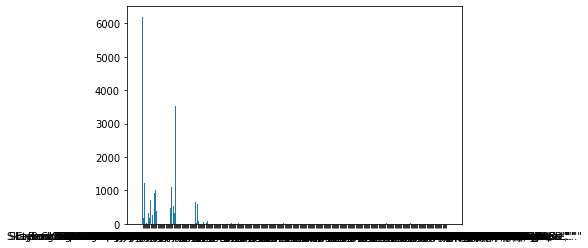

In [34]:
category_counts= Counter(category)
print(f"Total No. of Categories :",len(category_counts.keys()))
plt.bar(category_counts.keys(),category_counts.values())
plt.show() 

In [35]:
#only keeping the categories with more than 10 samples
new_dict={}
for key, value in category_counts.items():
  if value>10:
    new_dict[key]=value
#plt.bar(new_dict.keys(),new_dict.values())
#plt.show() 

In [36]:
print("total categories:", len(new_dict))
new_dict

total categories: 27


{'Automotive': 1012,
 'Baby Care': 483,
 'Bags, Wallets & Belts': 265,
 'Beauty and Personal Care': 710,
 'Cameras & Accessories': 82,
 'Clothing': 6197,
 'Computers': 578,
 'Footwear': 1227,
 'Furniture': 180,
 'Gaming': 35,
 'Health & Personal Care Appliances': 43,
 'Home & Kitchen': 24,
 'Home Decor & Festive Needs': 929,
 'Home Entertainment': 19,
 'Home Furnishing': 699,
 'Home Improvement': 81,
 'Jewellery': 3531,
 'Kitchen & Dining': 647,
 'Mobiles & Accessories': 1099,
 'Pens & Stationery': 313,
 'Pet Supplies': 30,
 'Sports & Fitness': 166,
 'Sunglasses': 35,
 'Tools & Hardware': 391,
 'Toys & School Supplies': 330,
 'Watches': 530,
 'eBooks': 15}

In [37]:
new_description=[]
new_category=[]
for i in range(len(description)):
  if category[i] in new_dict.keys():
    new_description.append(description[i])
    new_category.append(category[i])
    
new_df=pd.DataFrame()
new_df["description"]=new_description
new_df["category"]=new_category
new_df.head()

,description,category
0,key features of alisha solid women s cycling s...,Clothing
1,fabhomedecor fabric double sofa bed finish co...,Furniture
2,key features of aw bellies sandals wedges heel...,Footwear
3,key features of alisha solid women s cycling s...,Clothing
4,specifications of sicons all purpose arnica do...,Pet Supplies


In [38]:
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(new_df.category)
new_df['categorical_label'] = lab_enc.transform(new_df.category)
new_df.head()

,description,category,categorical_label
0,key features of alisha solid women s cycling s...,Clothing,5
1,fabhomedecor fabric double sofa bed finish co...,Furniture,8
2,key features of aw bellies sandals wedges heel...,Footwear,7
3,key features of alisha solid women s cycling s...,Clothing,5
4,specifications of sicons all purpose arnica do...,Pet Supplies,20


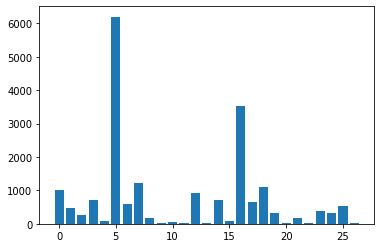

In [39]:
c=Counter(new_df['categorical_label'])
plt.bar(c.keys(),c.values())
plt.show() 

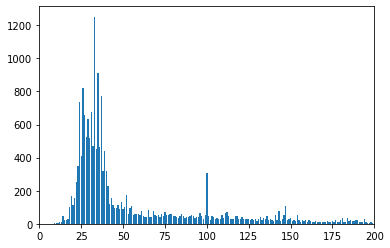

In [40]:
df=new_df["description"]
length=[]
for i in range(len(df)) :
  if type(df[i])==str:
    length.append(len(nltk.word_tokenize(df[i])))
c= Counter(length)
plt.bar(c.keys(),c.values())
plt.xlim(0,200)
plt.show() 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(new_df["description"], new_df["categorical_label"], test_size=0.15, random_state=42)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [42]:
strategy={0:2500,1:2500,2:2500,3:2500,4:2500,5:5500,6:2500,7:2500,8:2500,9:2500,10:2500,11:2500,12:2500,13:2500,14:2500,15:2500,16:4000,17:2500,18:2500,19:2500,20:2500,21:2500,22:2500,23:2500,24:2500,25:2500,26:2500}
Rand_over_sampling = RandomOverSampler(sampling_strategy=strategy)
X_train, y_train = Rand_over_sampling.fit_resample(np.array(X_train).reshape(-1,1), y_train)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (5500) in class 5 will be larger than the number of samples in the majority class (class #5 -> 5298)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


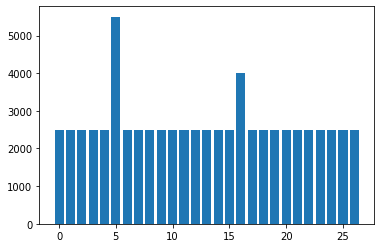

In [43]:
c=Counter(y_train)
plt.bar(c.keys(),c.values())
plt.show() 

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [45]:
sent_length=128
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train.reshape(-1))
sequences = tokenizer.texts_to_sequences(X_train.reshape(-1))
word_index = tokenizer.word_index
voc_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", voc_size)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_train=np.array(embedded_docs)

Vocabulary Size: 17750


In [46]:
sequences = tokenizer.texts_to_sequences(X_test)
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_test=np.array(embedded_docs)    

In [47]:
sequences = tokenizer.texts_to_sequences(X_val.reshape(-1))
embedded_docs=pad_sequences(sequences,padding='post',maxlen=sent_length)
X_val=np.array(embedded_docs)  

In [20]:
embedding_vector_features=100
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model1=Model(inputs=input, outputs=truth)
model1.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model1.summary()
#plot_model(model1,show_layer_names=True,show_shapes=True)

LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_LSTM_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 100)          1772600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1644

In [21]:
model1.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=LSTM_save, batch_size=64, epochs=4)

Epoch 1/4
900/900 [==============================] - 88s 94ms/step - loss: 0.8138 - accuracy: 0.7831 - val_loss: 0.0341 - val_accuracy: 0.9908
Epoch 2/4
900/900 [==============================] - 84s 93ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.0262 - val_accuracy: 0.9937
Epoch 3/4
900/900 [==============================] - 84s 93ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.0356 - val_accuracy: 0.9910
Epoch 4/4
900/900 [==============================] - 84s 93ms/step - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.0333 - val_accuracy: 0.9917


In [22]:
print("FOR LSTM MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_LSTM_27.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR LSTM MODEL
Accuracy: 0.951153
Precision: 0.820101
Recall: 0.798510
F1 score: 0.805993


Text(0.5, 1.0, 'CONFUSION MATRIX - LSTM MODEL')

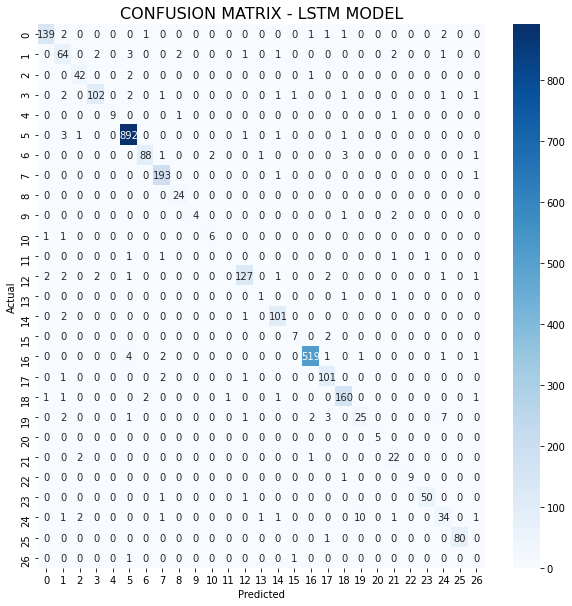

In [23]:
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSTM MODEL", size=16)

In [24]:
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model2=Model(inputs=input, outputs=truth)
model2.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model2.summary()
#plot_model(model3,show_layer_names=True,show_shapes=True)

CNN_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_CNN_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 100)          1772600   
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 128)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 128)           512       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097

In [25]:
model2.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_save, batch_size=64, epochs =5)

Epoch 1/5
900/900 [==============================] - 31s 33ms/step - loss: 0.7372 - accuracy: 0.8031 - val_loss: 0.0269 - val_accuracy: 0.9924
Epoch 2/5
900/900 [==============================] - 29s 32ms/step - loss: 0.0177 - accuracy: 0.9944 - val_loss: 0.0247 - val_accuracy: 0.9938
Epoch 3/5
900/900 [==============================] - 29s 32ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 0.0342 - val_accuracy: 0.9929
Epoch 4/5
900/900 [==============================] - 28s 31ms/step - loss: 0.0380 - accuracy: 0.9901 - val_loss: 0.0263 - val_accuracy: 0.9953
Epoch 5/5
900/900 [==============================] - 29s 32ms/step - loss: 0.0188 - accuracy: 0.9951 - val_loss: 0.0253 - val_accuracy: 0.9931


In [26]:
print("FOR CNN MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_CNN_27.hdf5')
y_prob = saved_model.predict(X_test)
y_pred = np.argmax(y_prob,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_pred,average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_pred,average='macro')
print('F1 score: %f' % f1)

FOR CNN MODEL
Accuracy: 0.960312
Precision: 0.808049
Recall: 0.772137
F1 score: 0.784594


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX - CNN MODEL')

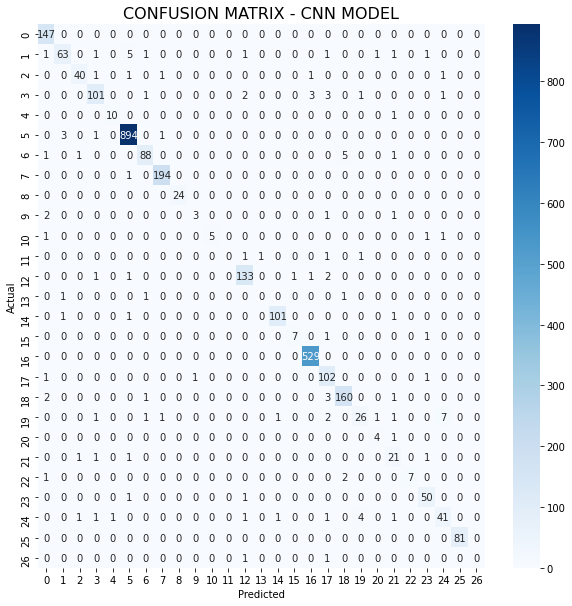

In [28]:
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(y_pred))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - CNN MODEL", size=16)

In [48]:
input=Input(shape=(sent_length,), name='inputs')
x=Embedding(voc_size,embedding_vector_features,input_length=sent_length)(input)
x=Conv1D(128, 5, padding='same', activation='relu' )(x)
x=MaxPooling1D(pool_size=2,strides=None)(x)
x=Bidirectional(LSTM(64))(x)
x=BatchNormalization()(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.4)(x)
truth=Dense(64,activation='relu')(x)
truth=Dense(27,activation='softmax',name='truth_')(truth)
model3=Model(inputs=input, outputs=truth)
model3.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model3.summary()
#plot_model(model5,show_layer_names=True,show_shapes=True)

CNN_LSTM_save = ModelCheckpoint('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_CNN_LSTM_27.hdf5', save_best_only=True, monitor='val_loss', mode='min')


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 128)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 128, 100)          1775000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 128)          64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0   

In [ ]:
model3.fit(x=X_train, y=y_train, validation_data=(X_val,y_val), callbacks=CNN_LSTM_save, batch_size=64, epochs =5)

Epoch 1/5
900/900 [==============================] - 68s 72ms/step - loss: 0.7193 - accuracy: 0.8071 - val_loss: 0.0254 - val_accuracy: 0.9924
Epoch 2/5
900/900 [==============================] - 64s 71ms/step - loss: 0.0222 - accuracy: 0.9935 - val_loss: 0.0197 - val_accuracy: 0.9946
Epoch 3/5
900/900 [==============================] - 64s 71ms/step - loss: 0.0270 - accuracy: 0.9918 - val_loss: 0.0375 - val_accuracy: 0.9910
Epoch 4/5
900/900 [==============================] - 64s 71ms/step - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0195 - val_accuracy: 0.9953
Epoch 5/5
495/900 [===============>..............] - ETA: 27s - loss: 0.0117 - accuracy: 0.9957

FOR CNN LSTM MODEL


Text(0.5, 1.0, 'CONFUSION MATRIX - IRIS DATASET')

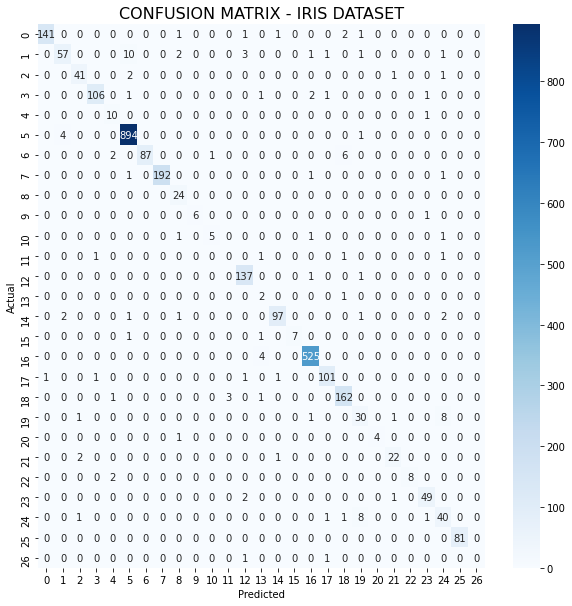

In [ ]:
print("FOR CNN LSTM MODEL")
saved_model=load_model('/content/drive/MyDrive/IIIT_MIDAS/saved_models/'+'OS_CNN_LSTM_27.hdf5')
y_prob = saved_model.predict(X_test)
yhat_classes = np.argmax(y_prob,axis=1)
conf_mat = confusion_matrix(lab_enc.inverse_transform(y_test), lab_enc.inverse_transform(yhat_classes))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - IRIS DATASET", size=16)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,yhat_classes))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       147
           1       0.90      0.75      0.82        76
           2       0.91      0.91      0.91        45
           3       0.98      0.95      0.96       112
           4       0.67      0.91      0.77        11
           5       0.98      0.99      0.99       899
           6       1.00      0.91      0.95        96
           7       1.00      0.98      0.99       195
           8       0.80      1.00      0.89        24
           9       1.00      0.86      0.92         7
          10       0.83      0.62      0.71         8
          11       0.00      0.00      0.00         4
          12       0.94      0.99      0.96       139
          13       0.20      0.67      0.31         3
          14       0.97      0.93      0.95       104
          15       1.00      0.78      0.88         9
          16       0.99      0.99      0.99       529
          17       0.96    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
